# Customer clustering based on Credit Card - Problem Statement


# Description

## Background and Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

# Objective



To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.







 







## Data Description

- The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary** 

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)


# Let's start coding!

## Importing necessary libraries

In [5]:
# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to use standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [7]:
# Let's load the data from excel file
data = pd.read_excel('Credit+Card+Customer+Data.xlsx')

In [8]:
# checking shape of the data
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")

There are 660 rows and 7 columns.


In [9]:
#load the head of the data
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [10]:
#load the tail of the data
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [11]:
# let's view a sample of the data
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


## Observations

- `Sl_No` is just an index for the data entry and will add no value to our analysis. So, we will drop it.

- All the columns here contain only numerical data type.

- There seems to be no missing values. But as this is only the sample data, it needs further investigation.

In [12]:
pd.DataFrame(data={'% of Missing Values':round(data.isna().sum()/data.isna().count()*100,2)})

,% of Missing Values
Sl_No,0.0
Customer Key,0.0
Avg_Credit_Limit,0.0
Total_Credit_Cards,0.0
Total_visits_bank,0.0
Total_visits_online,0.0
Total_calls_made,0.0


- So, there is no missing value. The whole data looks like in a good shape. 

In [13]:
# let's create a copy of the data to avoid any changes to original data
df = data.copy()

In [14]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [15]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.50,190.67,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.44,25627.77,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.24,37625.49,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.71,2.17,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.40,1.63,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.61,2.94,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.58,2.87,0.0,1.00,3.0,5.00,10.0


# Observations

- The data is well-organized as there is missing value.

- `Avg_Credit_Limit` , `Customer_Key` are the columns that shows wide variation. 

- `Avg_Credit_Limit` , `Customer_Key` are showing a wide range of standard deviation. So, there is a possiblility of outlier treatment which needs furthur investigation. 

- `Total_Credit_Cards` column is showing a range of minimum 1 to maximum 10. It means the bank might be offering different kind of credit cards based on the requirements of the customer.



In [16]:
# checking for duplicate values
df.duplicated().sum()

0

- There is no duplicate value in the dataset.

In [17]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- **`Sl_No`** is showing unique values everytime. So, we can drop it as it is not contributing in the final decision making.

In [18]:
#Dropping CustomerID column
df.drop(columns='Sl_No',inplace=True)

In [19]:
# checking column datatypes and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


# Observations

- There is no missing value, so, the data is ready to be used for different sort of analysis.

- The data types of all the features are of integer types. So, we can directly use this type of data for finding our desired groups.


# Exploratory Data Analysis

# Univariate Analysis

### Histogram 

In [20]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

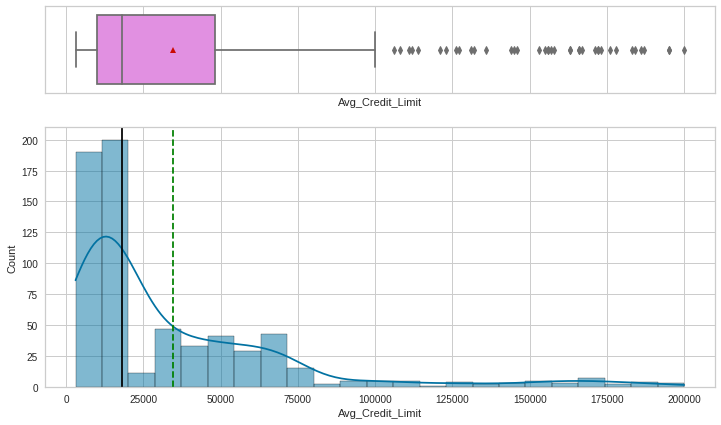

In [21]:
histogram_boxplot(df, "Avg_Credit_Limit", kde=True)

### Observations

- As expected from data description, we have found a number of outliers in the `Avg_Credit_Limit` analysis. But we cannot directly ignore these max values as outlier. As each customer is holding a maximum 10 number of cards, there might be any kind of card that has this kind of `Avg_Credit_Limit`.

- This graph is right-skewed having a long tail to the right.


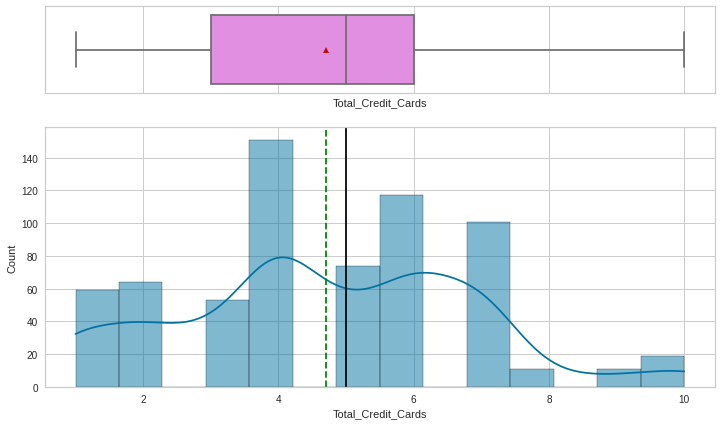

In [22]:
histogram_boxplot(df, "Total_Credit_Cards", kde=True)

### Observations


- This graph shows a double hump shape like that in the back of a camel. So, we might try to use log transformation technique. But, it's not a mandatory one.

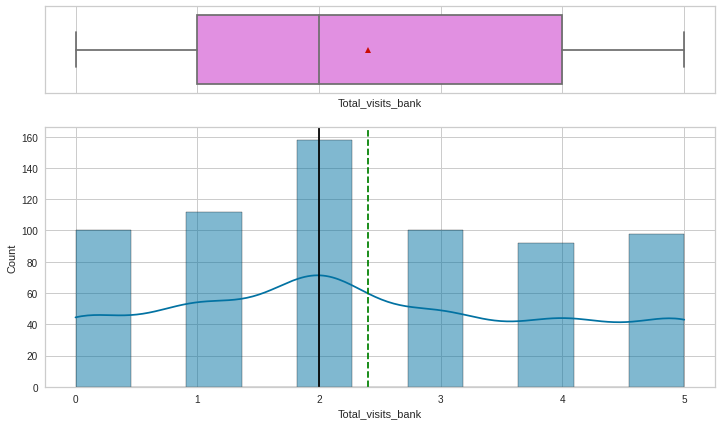

In [23]:
histogram_boxplot(df, "Total_visits_bank", kde=True)

### Observations

- As the median here is slightly smaller than the mean, this might be called partially right skewed. 

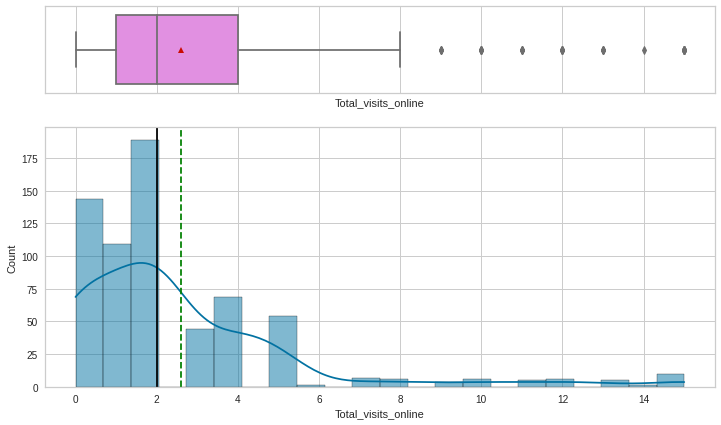

In [24]:
histogram_boxplot(df, "Total_visits_online", kde=True)

### Observations

- As the median here is relatively smaller than the mean, this can be called  right-skewed distribution with long tail to the right along with the vibrant presence of a number of outliers. But, we cannot directly ignore the presence of outliers, as the total number of visits online may happen upto this kind of high range having a maximum of 15.

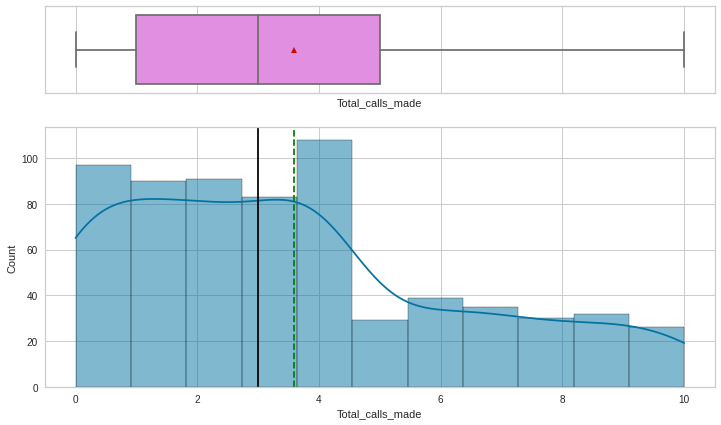

In [25]:
histogram_boxplot(df, "Total_calls_made", kde=True)

### Observations

- This graph shows several humps wih long righ tail  distribution. So, we can use optional treatment of log transformation to get the close shape of the distribution.

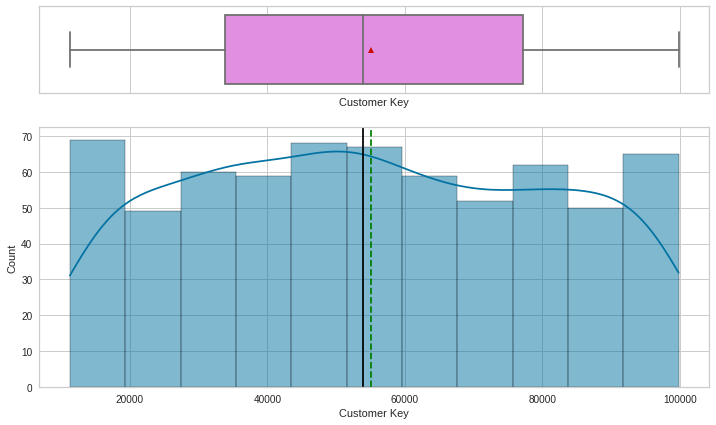

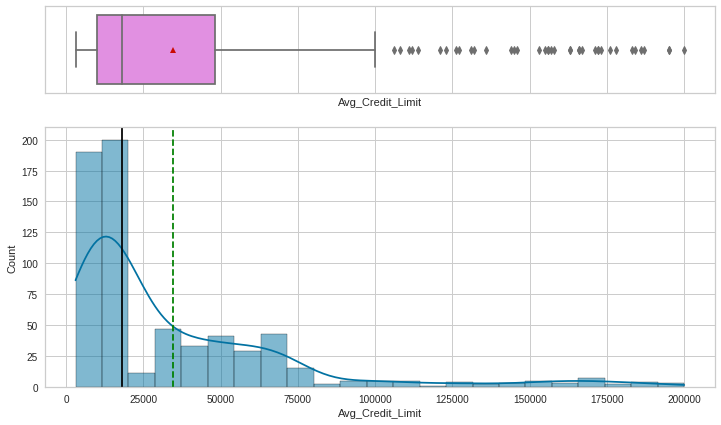

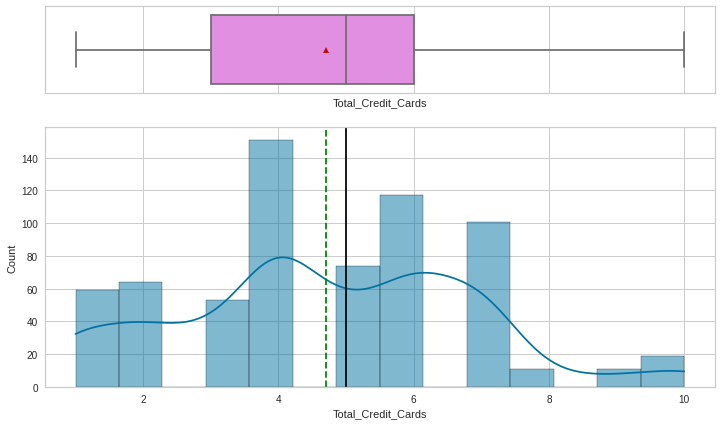

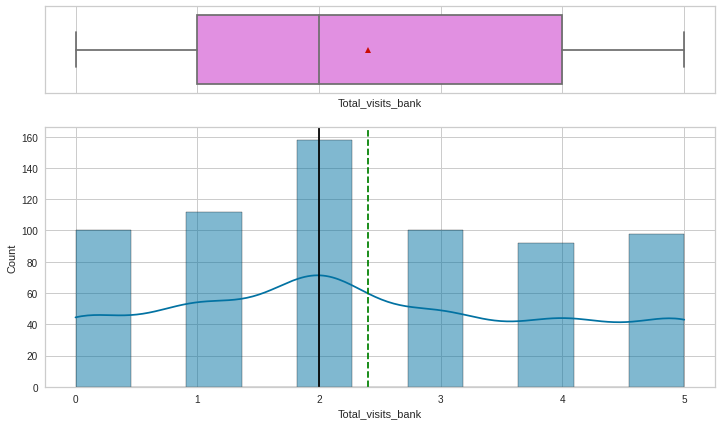

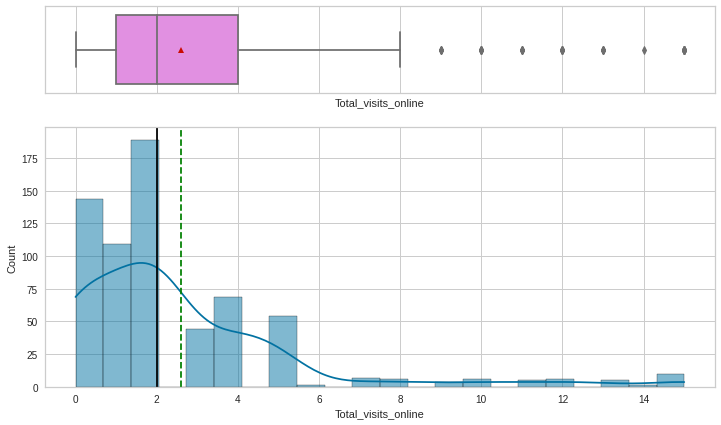

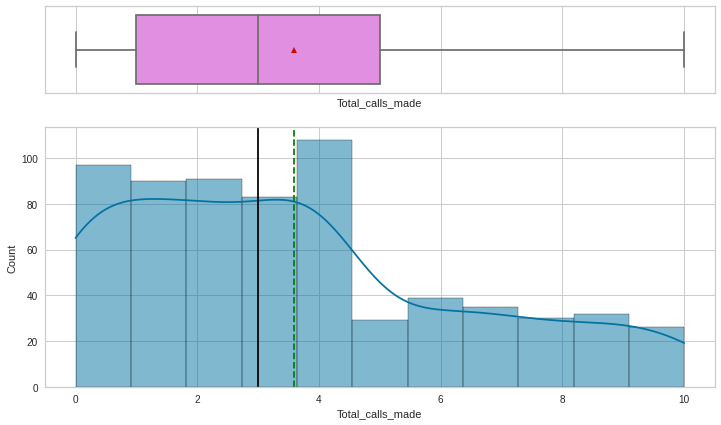

In [26]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde= True)

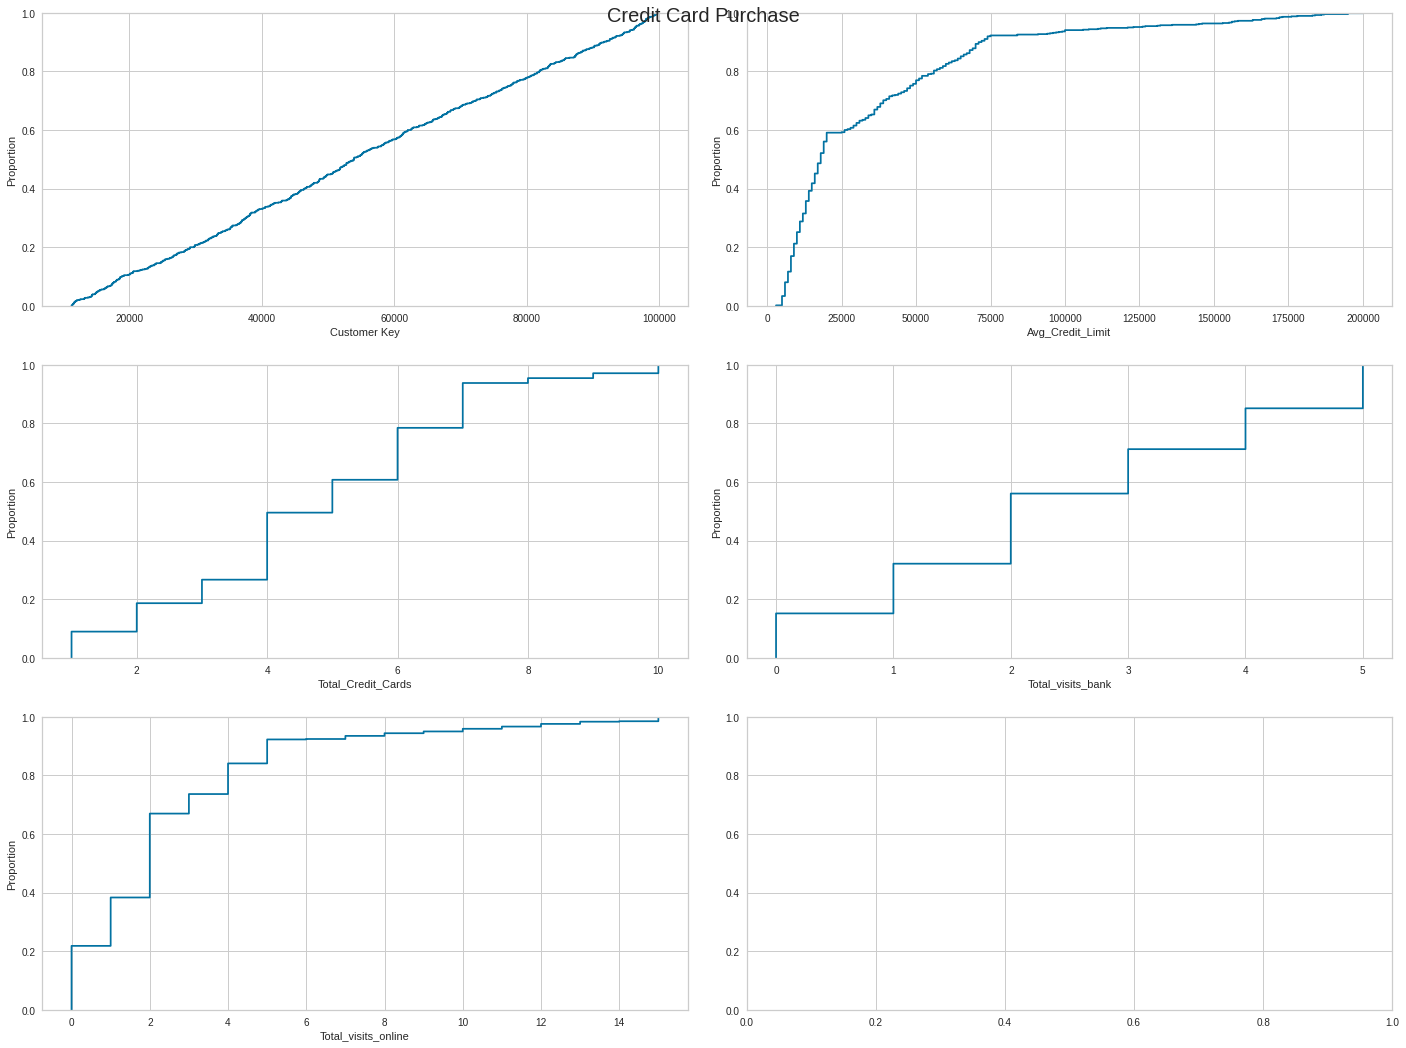

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("Credit Card Purchase", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 90% of the customers have visited online less than 5 times yearly.
- 95% of the customers possess 7 or less than 7 credit cards.
- 75% of the customers have visited the bank3 or less than 3 times.
- 90% of the customers have average credit card limit for all credit cards is less than 75000.


## Barplot

In [28]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

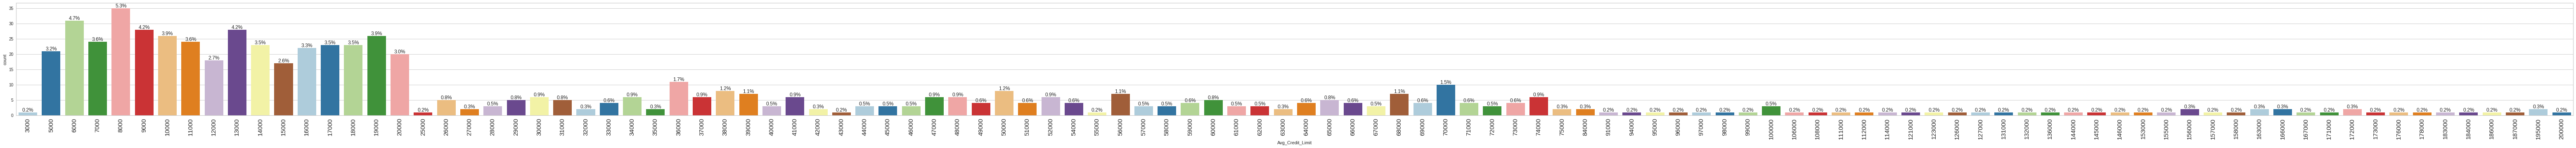

In [29]:
labeled_barplot(df, "Avg_Credit_Limit", perc=True)

### Observations

- The percentage of average credit limit having an amount of 8000 is the highest. The majority density of credit card limit is around this amount.

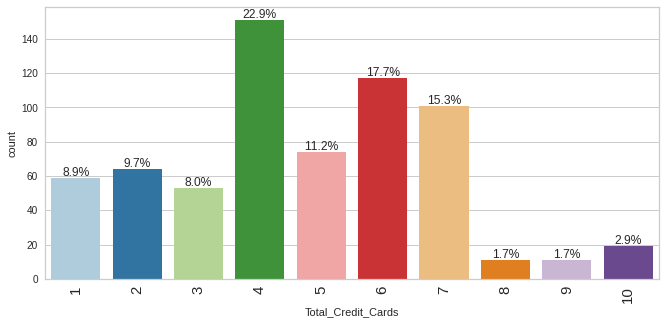

In [30]:
labeled_barplot(df, "Total_Credit_Cards", perc=True)

### Observations

- The highest percentage of customers having `Total Credit Cards` is 4. 

- The lowest percentage of customers having `Total Credit Cards` is 8 & 9. 


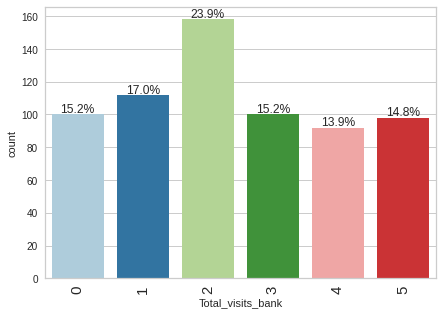

In [31]:
labeled_barplot(df, "Total_visits_bank", perc=True)

### Observations

- The highest percentage of `Total Visits Bank` is 2 in this dataset. 
- The customers are likely to visit banks more often while taking credit card services. 

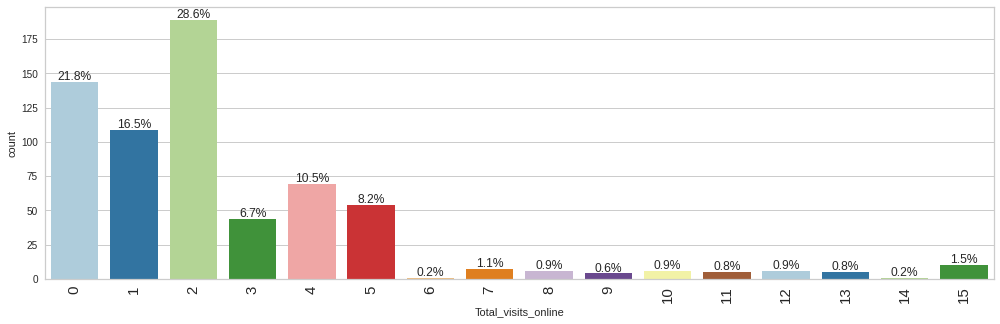

In [32]:
labeled_barplot(df, "Total_visits_online", perc=True)

### Observations

- The highest percentage of `Total Visits Online` is 2 in this dataset. 
- The customers are likely to visit online less frequently as compared to offline visit while taking credit card services.

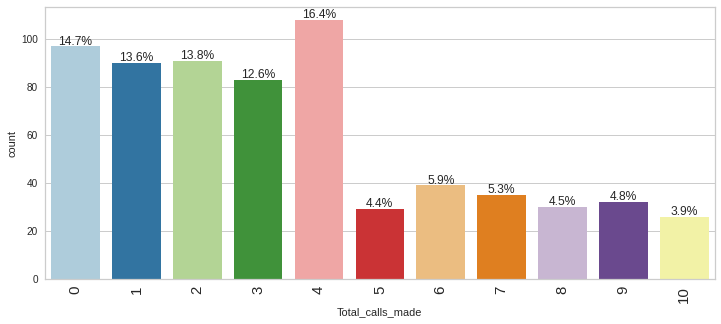

In [33]:
labeled_barplot(df, "Total_calls_made", perc=True)

### Observations

- The highest percentage of `Total Calls Made` is 4 in this dataset. 

- The customers are likely to call less than or equal to 4 times while taking credit card services.

## Bivariate Analysis

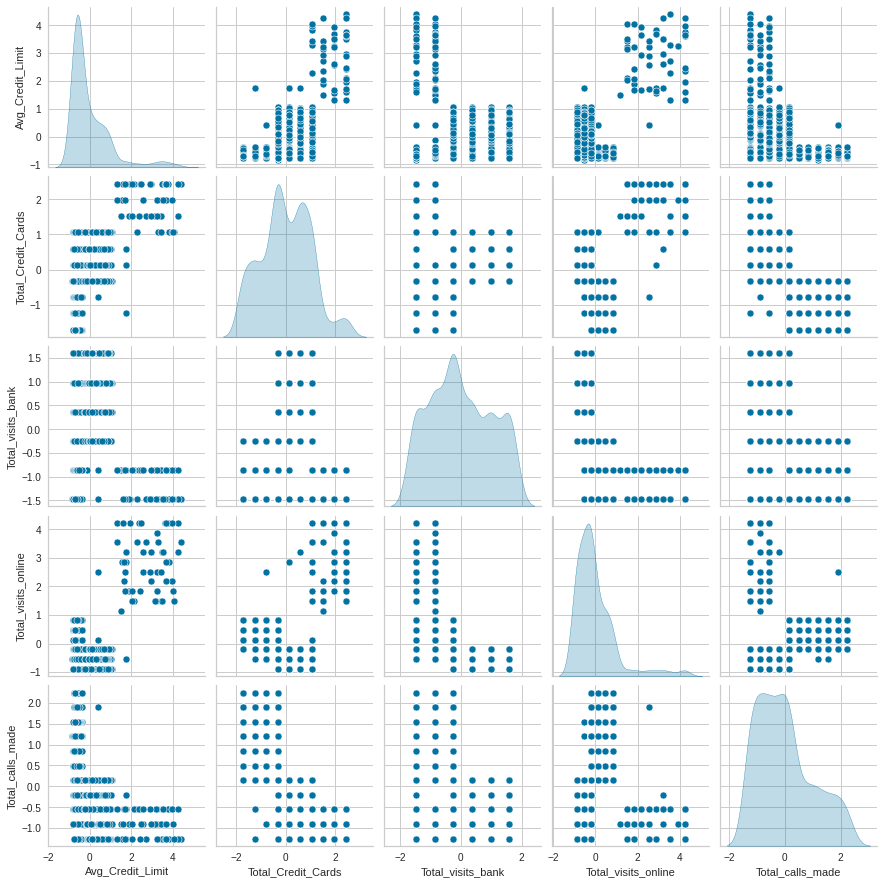

In [34]:
dfAttr= df.iloc[:,1:]
dfScaled= dfAttr.apply(zscore)
sns.pairplot(dfScaled,diag_kind='kde')

### Observations

- There is not much noticable positive or negative correlation between the variables.

- The distribution is more off scattered type.

- The diagonals of the distribution is showing multiple hump shapes and there is no sign of normal distribution. 

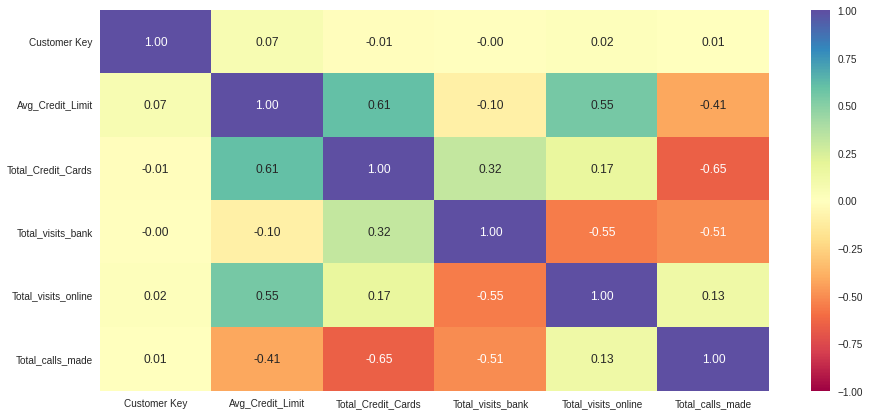

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

### Observations

- There is no data that shows highly positive or negative correlation.

### Data Preprocessing

In [36]:
# variables used for clustering
num_col

['Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [37]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [38]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## Group Data into similar clusters

- Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

CPU times: user 1.25 s, sys: 389 ms, total: 1.64 s
Wall time: 870 ms


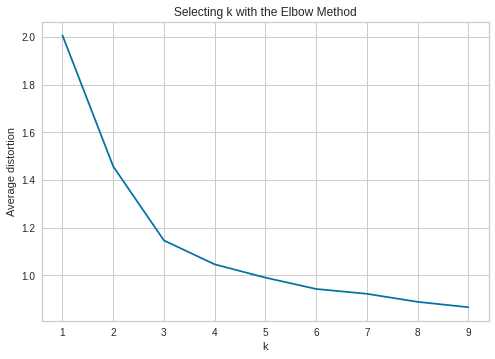

In [39]:
%%time
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(dfScaled)
    prediction=model.predict(dfScaled)
    meanDistortions.append(sum(np.min(cdist(dfScaled, model.cluster_centers_, 'euclidean'), axis=1)) / dfScaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

- Though the bend is not coming out clearly as there are many bends, let us look at 3 clusters and 4 clusters

**Let's check the silhouette scores.**

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2726898791817692)
For n_clusters = 6, the silhouette score is 0.2555645280295032)
For n_clusters = 7, the silhouette score is 0.248175083050816)
For n_clusters = 8, the silhouette score is 0.22728473535295687)
For n_clusters = 9, the silhouette score is 0.2236340139799295)


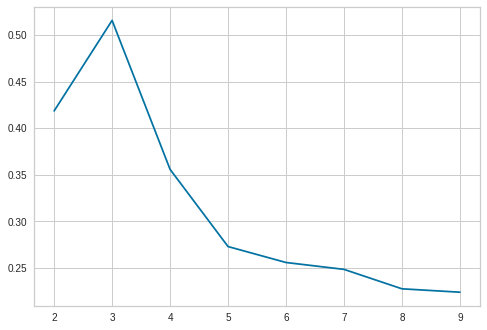

In [40]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((dfScaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(dfScaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 3 is higher than that for 4. So, we will choose 3 as value of k.**

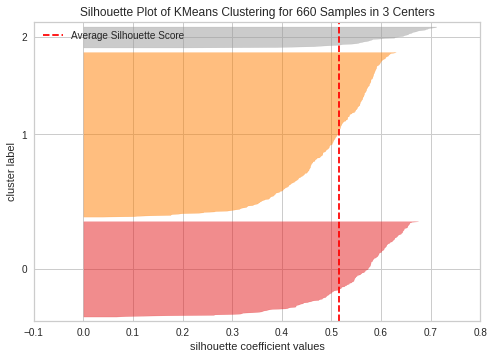

In [41]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(dfScaled)
visualizer.show()

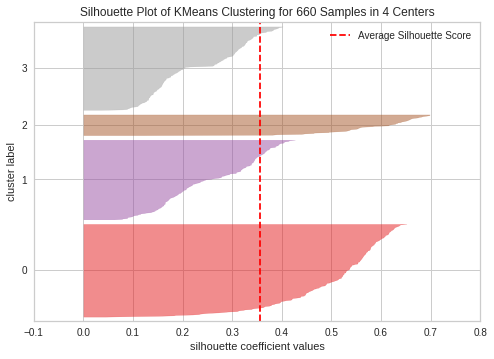

In [42]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(dfScaled)
visualizer.show()

In [43]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dfScaled)

KMeans(n_clusters=3, random_state=0)

In [44]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
dfScaled["K_means_segments"] = kmeans.labels_

## Cluster Profiling

In [45]:
cluster_profile = df.groupby("K_means_segments").mean()

In [46]:
%%time
cluster_profile["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

CPU times: user 2.39 ms, sys: 38 µs, total: 2.42 ms
Wall time: 2.59 ms


In [47]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightyellow", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


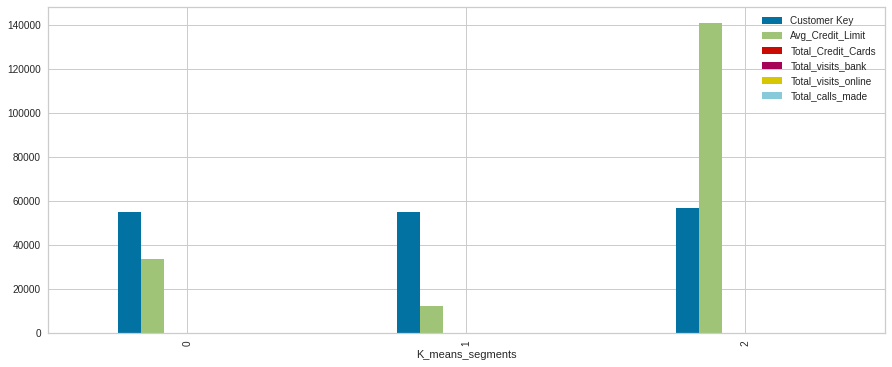

In [50]:
df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

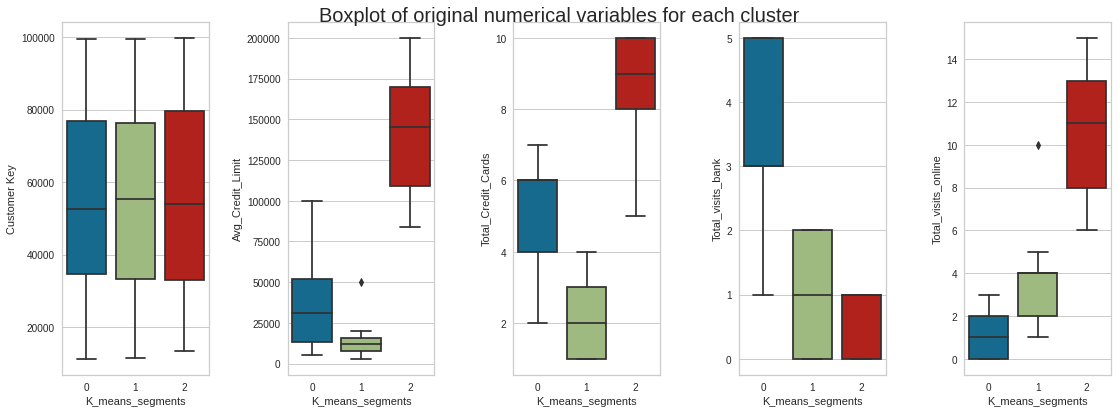

In [71]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Insights**

**Cluster 0**
- Average Credit Limit  of the customer is moderate.
- Total Credit Cards  of the customer is moderate.
- Total Visits of the customer to bank is the highest.
- Total Visits of the customer online is the lowest.
- Total Calls Made is also moderate.
- Count in each segment is also the highest.

**Cluster 1**
- Average Credit Limit  of the customer is the lowest.
- Total Credit Cards  of the customer is the lowest.
- Total Visits of the customer to bank is the lowest.
- Total Visits of the customer online is moderate.
- Total Calls Made is the highest.
- Count in each segment is moderate.

**Cluster 2**
- Average Credit Limit  of the customer is the highest.
- Total Credit Cards  of the customer is the highest.
- Total Visits of the customer to bank is the lowest.
- Total Visits of the customer online is the highest.
- Total Calls Made is also the lowest.
- Count in each segment is also the lowest.

## Hierarchical Clustering

In [52]:
%%time
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7158261475030842.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8333358686900459.
Cophenetic correlation for Euclidean distance and average linkage is 0.8684228720933055.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8642251666438747.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6993328509872334.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7832281429250635.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8628342866871905.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8345913036690694.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6829750720107938.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6051316784974626.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7754307051655686.
Cophenetic co

In [53]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8684228720933055, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [54]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7158261475030842.
Cophenetic correlation for complete linkage is 0.8333358686900459.
Cophenetic correlation for average linkage is 0.8684228720933055.
Cophenetic correlation for centroid linkage is 0.8656427328161594.
Cophenetic correlation for ward linkage is 0.7067190998109724.
Cophenetic correlation for weighted linkage is 0.8642251666438747.


In [55]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8684228720933055, which is obtained with average linkage.


## Observations:

- We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.


**Let's see the dendrograms for the different linkage methods.**

CPU times: user 5.03 s, sys: 605 ms, total: 5.63 s
Wall time: 5.07 s


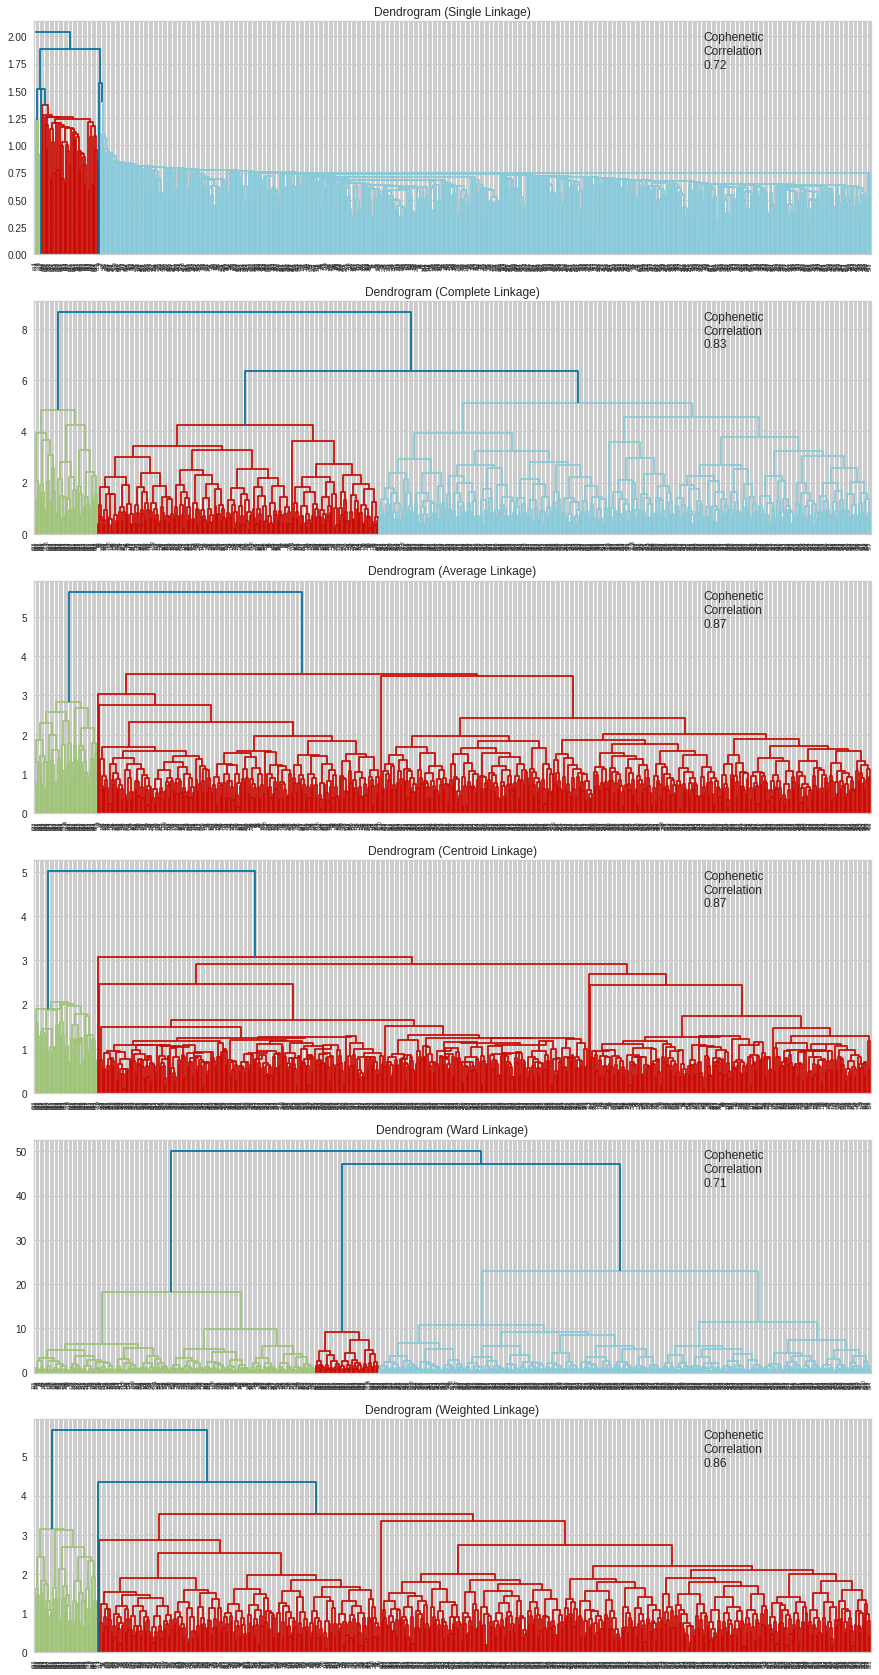

In [56]:
%%time
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [57]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.715826
1,complete,0.833336
2,average,0.868423
3,centroid,0.865643
4,ward,0.706719
5,weighted,0.864225


**Observations**

- The cophenetic correlation is the highest for average and centroid linkage methods.

- We will move ahead with average linkage.

- The number of appropriate clusters would be 3. So, we will move ahead with it. 

**Let's see the dendrogram for Mahalanobis and Manhattan distances with average and weighted linkage methods (as they gave high cophenetic correlation values).**

CPU times: user 4.35 s, sys: 363 ms, total: 4.72 s
Wall time: 5.78 s


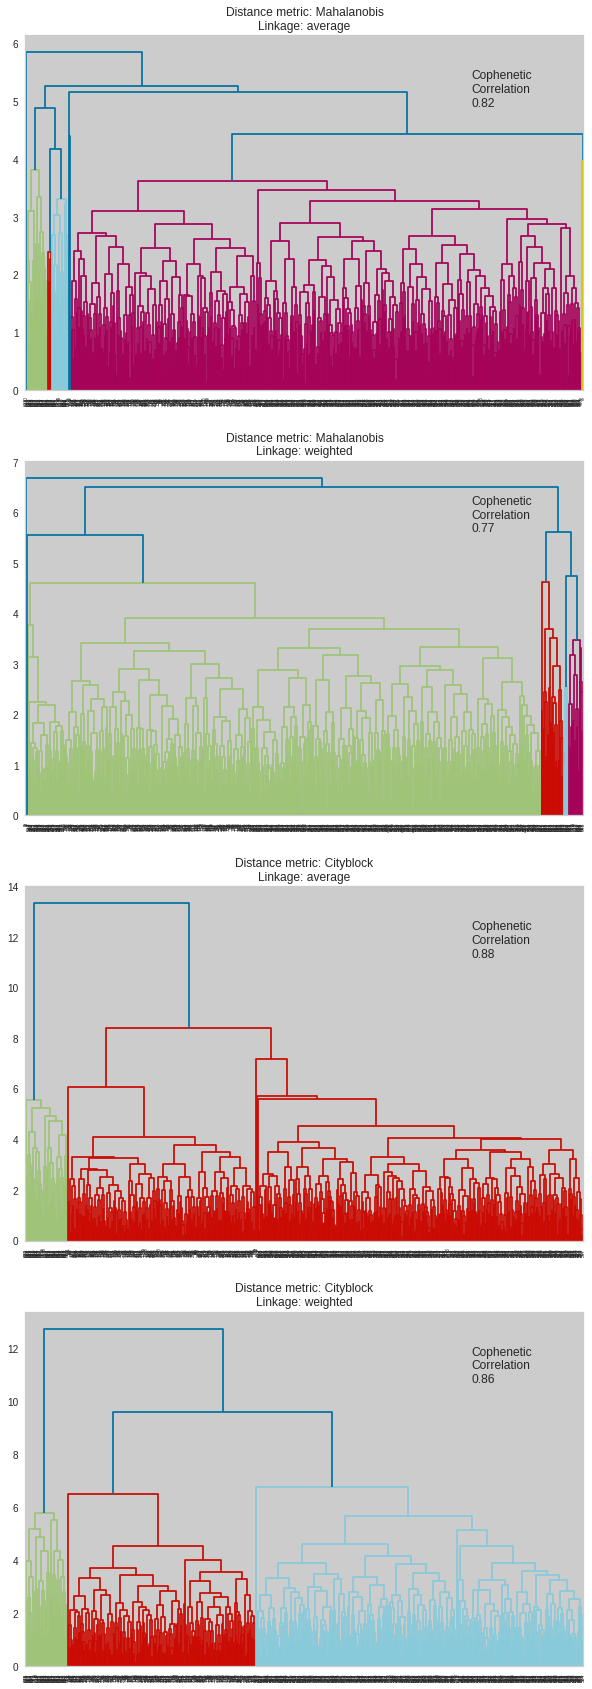

In [74]:
%%time
# list of distance metrics
distance_metrics = ["mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with average linkage gave us separate and distinct clusters.
- 3 would be the appropriate number of the clusters from the dendrogram with average linkage method. 

**Let's create 3 clusters.**

In [59]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=3)

In [60]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling

In [61]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [62]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Total_Credit_Cards"].count().values
)

In [63]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightyellow", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,,
0,54829.721649,33688.144330,5.505155,3.476804,0.987113,2.002577,0.005155,388
1,55333.256757,12144.144144,2.400901,0.932432,3.567568,6.909910,1.000000,222
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50


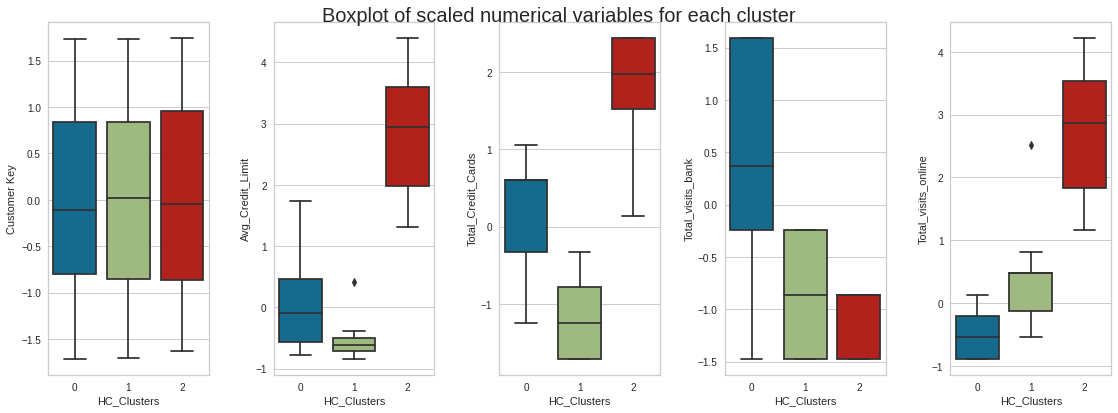

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

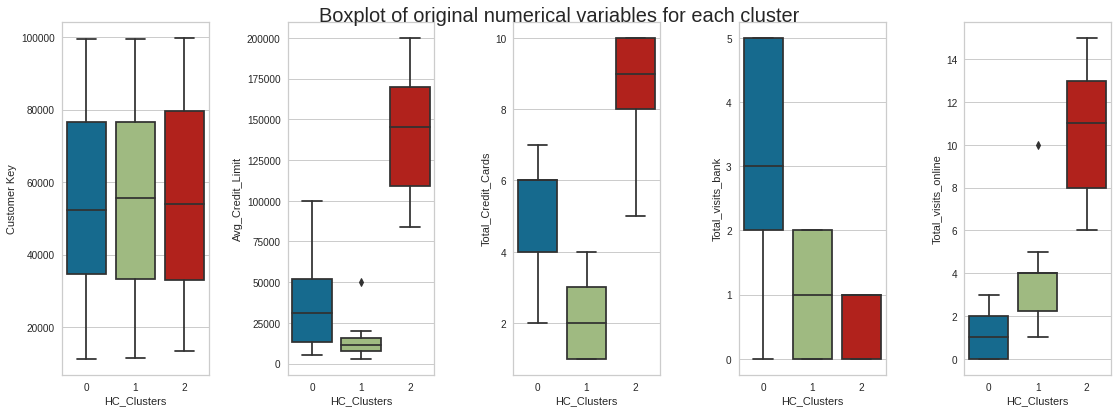

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights


**Cluster 0**
- Average Credit Limit  of the customer is moderate.
- Total Credit Cards  of the customer is moderate.
- Total Visits of the customer to bank is the highest.
- Total Visits of the customer online is the lowest.
- Total Calls Made is also moderate.
- Count in each segment is also the highest.

**Cluster 1**
- Average Credit Limit  of the customer is the lowest.
- Total Credit Cards  of the customer is the lowest.
- Total Visits of the customer to bank is the lowest.
- Total Visits of the customer online is moderate.
- Total Calls Made is the highest.
- Count in each segment is moderate.

**Cluster 2**
- Average Credit Limit  of the customer is the highest.
- Total Credit Cards  of the customer is the highest.
- Total Visits of the customer to bank is the lowest.
- Total Visits of the customer online is the highest.
- Total Calls Made is also the lowest.
- Count in each segment is also the lowest.

## K-means vs Hierarchical Clustering

**Observations**
- K-means clustering took less time to provide the results as compared to hierarchical clustering. So, K-means clustering is faster.
- The limitation of K-means clustering is that we are assuming K. So, it has become user input type. But, in hierarchical clustering method, we are getting general outcome that is provided by the result of the given model. So, the decision making from hierarchical clustering module becomes a little bit easier. 
- The cluster profiles that are obtained from K-means clustering and hierarchical clustering is more or less found the same in this case. So, there is no significant difference in this two methods for this dataset.

## Business Recommendations

- Cluster 0 consists of moderate customers who can spend intermediately. So, focused marketing campaigns can be done to target customers with higher purchasing power. But, this segment of customer might become handy as there purchasing ability in credit might be improved in near future.

- Cluster 1 consists of relatively weak in terms of financial condition right now. They might be struggling due to current covid situation which might make them unable to spend in credit. So, we should ignore this segment of customers while marketing this kind of credit based service right now.  

- Cluster 2 consists of the customers having the highest purchasing power ability in credit. Though the count in this segment is the lowest in the dataset, we should focus more in this segment to get some instantaneous outcome.